In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the FER2013 dataset
df = pd.read_csv(r"H:\Sparsh Ehsaas Documents\Ehsaas\ML\fer2013.csv")
print(df.shape)
print(df.head())

# Define the emotion label to text mapping
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
INTERESTED_LABELS = [3, 4]

# Filter the dataset to include only interested labels
df = df[df.emotion.isin(INTERESTED_LABELS)]

# Preprocess the image data
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

# Encode the labels
le = LabelEncoder()
img_labels = le.fit_transform(df['emotion'])
img_labels = to_categorical(img_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)

# Normalize the image data
X_train = X_train / 255.
X_test = X_test / 255.

# Define the CNN model
def build_net():
    net = Sequential(name='DCNN')
    net.add(Conv2D(filters=256,kernel_size=(5,5),input_shape=(48, 48, 1),activation='relu',
                   padding='same',kernel_initializer='he_normal', name='conv2d_1'))
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',padding='same',kernel_initializer='he_normal',
                name='conv2d_2'))
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))
    net.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',
                name='conv2d_3'))
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',
                name='conv2d_4'))
    net.add(BatchNormalization(name='batchnorm_4'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))
    net.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',
                name='conv2d_5'))
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',
                name='conv2d_6'))
    net.add(BatchNormalization(name='batchnorm_6'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))
    net.add(Flatten(name='flatten'))
    net.add(Dense(128,activation='relu',kernel_initializer='he_normal',name='dense_1'))
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(0.6, name='dropout_4'))
    net.add(Dense(2,activation='softmax',name='out_layer'))

    net.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    net.summary()
    
    return net



(35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [2]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.00005,patience=10,verbose=1,restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=7,min_lr=1e-7,verbose=1)
callbacks = [early_stopping, lr_scheduler]

# Define data augmentation
train_datagen = ImageDataGenerator(rotation_range=15,width_shift_range=0.15,height_shift_range=0.15,
    shear_range=0.15,zoom_range=0.15,horizontal_flip=True)
train_datagen.fit(X_train)

# Set hyperparameters
batch_size = 64 
epochs = 40

# Build and train the model
model = build_net() 
steps_per_epoch = int(len(X_train) / batch_size)  # Ensure steps_per_epoch is an integer
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    callbacks=callbacks)

# Save the trained model
model.save("final_model.h5.keras")

C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 256)         │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,191,554 (12.17 MB)

 Trainable params: 3,188,994 (12.17 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/40


C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.5665 - loss: 0.8599 - val_accuracy: 0.6178 - val_loss: 0.6570 - learning_rate: 0.0010
Epoch 2/40
  1/188 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.5781 - loss: 0.6525

C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.5781 - loss: 0.6525 - val_accuracy: 0.6158 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.6198 - loss: 0.6851 - val_accuracy: 0.6178 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.5312 - loss: 0.7339 - val_accuracy: 0.6248 - val_loss: 0.6325 - learning_rate: 0.0010
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.6669 - loss: 0.6180 - val_accuracy: 0.7415 - val_loss: 0.5102 - learning_rate: 0.0010
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 160ms/step - accuracy: 0.6875 - loss: 0.5887 - val_accuracy: 0.7495 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.7426 - loss: 0.5229 - val_accuracy: 0.7432 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - accuracy: 0.7031 - loss: 0.584

In [12]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

model = load_model(r"C:\Users\ehsaa\Downloads\final_model.h5.keras")
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=list(emotion_label_to_text.values()))
print(report)

225/225 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step
              precision    recall  f1-score   support

       anger       0.11      0.33      0.16       991
     disgust       0.02      0.66      0.03       109
        fear       0.00      0.00      0.00      1024
   happiness       0.00      0.00      0.00      1798
     sadness       0.00      0.00      0.00      1216
    surprise       0.00      0.00      0.00       800
     neutral       0.00      0.00      0.00      1240

    accuracy                           0.06      7178
   macro avg       0.02      0.14      0.03      7178
weighted avg       0.01      0.06      0.02      7178



C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [22]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the FER2013 dataset
df = pd.read_csv(r"H:\Sparsh Ehsaas Documents\Ehsaas\ML\fer2013.csv")
print(df.shape)
print(df.head())

# Define the emotion label to text mapping
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Preprocess the image data
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

# Encode the labels
le = LabelEncoder()
img_labels = le.fit_transform(df['emotion'])
img_labels = to_categorical(img_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=42)

# Normalize the image data
X_train = X_train / 255.
X_test = X_test / 255.

# Define the CNN model for multi-class classification
def build_advanced_net():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

(35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=10, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
callbacks = [early_stopping, lr_scheduler]

# Define data augmentation
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_datagen.fit(X_train)

# Set hyperparameters
batch_size = 64
epochs = 50

# Build and train the model
model = build_net()
steps_per_epoch = len(X_train) // batch_size  # Ensure steps_per_epoch is an integer
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test), steps_per_epoch=steps_per_epoch, callbacks=callbacks)

# Save the trained model
model.save("final_model_all_emotions.h5.keras")

C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 256)         │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,192,199 (12.18 MB)

 Trainable params: 3,189,639 (12.17 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/50


C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/448 ━━━━━━━━━━━━━━━━━━━━ 8:39 2s/step - accuracy: 0.1735 - loss: 2.7909

In [18]:
print("TRAIN size: ",len( X_train))
print("TEST size: ", len(X_test))

TRAIN size:  28709
TEST size:  7178


In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Activation
from tensorflow.keras.models import Model

# Load the FER2013 dataset
df = pd.read_csv(r"H:\Sparsh Ehsaas Documents\Ehsaas\ML\fer2013.csv")
print(df.shape)
print(df.head())

# Define the emotion label to text mapping
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Preprocess the image data
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

# Encode the labels
le = LabelEncoder()
img_labels = le.fit_transform(df['emotion'])
img_labels = to_categorical(img_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=42)

# Normalize the image data
X_train = X_train / 255.
X_test = X_test / 255.


def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    """A residual block."""
    shortcut = x
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, name=name+'_0_conv')(x)
        shortcut = BatchNormalization(name=name+'_0_bn')(shortcut)
    
    x = Conv2D(filters, kernel_size, padding='same', strides=stride, name=name+'_1_conv')(x)
    x = BatchNormalization(name=name+'_1_bn')(x)
    x = Activation('relu', name=name+'_1_relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same', name=name+'_2_conv')(x)
    x = BatchNormalization(name=name+'_2_bn')(x)
    
    x = Add(name=name+'_add')([shortcut, x])
    x = Activation('relu', name=name+'_out')(x)
    return x

def build_net(input_shape=(48, 48, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_initial')(inputs)
    x = BatchNormalization(name='batchnorm_initial')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='maxpool2d_initial')(x)

    x = residual_block(x, 64, conv_shortcut=True, name='resblock_1')
    x = residual_block(x, 128, conv_shortcut=True, name='resblock_2')
    x = MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2')(x)
    x = residual_block(x, 256, conv_shortcut=True, name='resblock_3')
    x = MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='dense_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    x = Dense(7, activation='softmax', name='out_layer')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

(35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced rotation range
    width_shift_range=0.1,  # Reduced shift range to prevent too much distortion
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-6, verbose=1)
callbacks = [early_stopping, lr_scheduler]

# Set hyperparameters
epochs = 100  # Increased number of epochs for potentially better training
batch_size= 62
# Build and train the model
model = build_net()
steps_per_epoch = len(X_train) // batch_size  # Ensure steps_per_epoch is an integer
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test), steps_per_epoch=steps_per_epoch, callbacks=callbacks)

# Save the trained model
model.save("final_model_all_emotions.h5.keras")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 48, 48, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_initial (Conv2D)       │ (None, 48, 48, 64)        │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batchnorm_initial             │ (None, 48, 48, 64)        │             256 │ conv2d_initial[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ maxpool2d_initial             │ (None, 24, 24, 64)        │               0 │ batchnorm_initial[0][0]    │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_1_conv (Conv2D)    │ (None, 24, 24, 64)        │          36,928 │ maxpool2d_initial[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_1_bn               │ (None, 24, 24, 64)        │             256 │ resblock_1_1_conv[0][0]    │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_1_relu             │ (None, 24, 24, 64)        │               0 │ resblock_1_1_bn[0][0]      │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_0_conv (Conv2D)    │ (None, 24, 24, 64)        │           4,160 │ maxpool2d_initial[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_2_conv (Conv2D)    │ (None, 24, 24, 64)        │          36,928 │ resblock_1_1_relu[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_0_bn               │ (None, 24, 24, 64)        │             256 │ resblock_1_0_conv[0][0]    │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_2_bn               │ (None, 24, 24, 64)        │             256 │ resblock_1_2_conv[0][0]    │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_add (Add)          │ (None, 24, 24, 64)        │               0 │ resblock_1_0_bn[0][0],     │
│                               │                           │                 │ resblock_1_2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_1_out (Activation)   │ (None, 24, 24, 64)        │               0 │ resblock_1_add[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resblock_2_1_conv (Conv2D)    │ (None, 24, 24, 128)       │          73,85

 Total params: 10,677,703 (40.73 MB)

 Trainable params: 10,674,887 (40.72 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/100


C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/463 ━━━━━━━━━━━━━━━━━━━━ 210s 446ms/step - accuracy: 0.2252 - loss: 5.2117 - val_accuracy: 0.2541 - val_loss: 1.7804 - learning_rate: 0.0010
Epoch 2/100
  1/463 ━━━━━━━━━━━━━━━━━━━━ 3:24 442ms/step - accuracy: 0.3065 - loss: 1.7877

C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3065 - loss: 1.7877 - val_accuracy: 0.2538 - val_loss: 1.7797 - learning_rate: 0.0010
Epoch 3/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 217s 468ms/step - accuracy: 0.2841 - loss: 1.7554 - val_accuracy: 0.2785 - val_loss: 1.7599 - learning_rate: 0.0010
Epoch 4/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2903 - loss: 1.7287 - val_accuracy: 0.2868 - val_loss: 1.7471 - learning_rate: 0.0010
Epoch 5/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 217s 469ms/step - accuracy: 0.3343 - loss: 1.6689 - val_accuracy: 0.4015 - val_loss: 1.5427 - learning_rate: 0.0010
Epoch 6/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3387 - loss: 1.6971 - val_accuracy: 0.3559 - val_loss: 1.6158 - learning_rate: 0.0010
Epoch 7/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 218s 470ms/step - accuracy: 0.3701 - loss: 1.5944 - val_accuracy: 0.3735 - val_loss: 1.5774 - learning_rate: 0.0010
Epoch 8/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.3710 - 

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step
              precision    recall  f1-score   support

       anger       0.58      0.64      0.61       991
     disgust       0.79      0.24      0.37       109
        fear       0.56      0.39      0.46      1024
   happiness       0.86      0.86      0.86      1798
     sadness       0.54      0.54      0.54      1216
    surprise       0.80      0.73      0.76       800
     neutral       0.57      0.73      0.64      1240

    accuracy                           0.66      7178
   macro avg       0.67      0.59      0.61      7178
weighted avg       0.67      0.66      0.66      7178



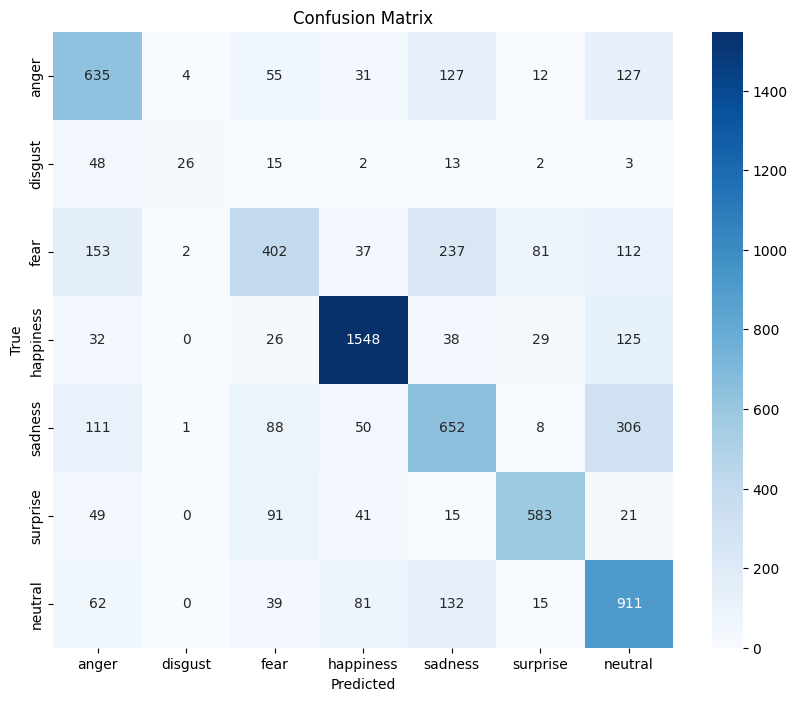

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

model=load_model(r'C:\Users\ehsaa\Downloads\final_model_all_emotions.h5.keras')

# Assuming emotion_label_to_text is defined
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
target_names = list(emotion_label_to_text.values())

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=target_names)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the FER2013 dataset
df = pd.read_csv(r"H:\Sparsh Ehsaas Documents\Ehsaas\ML\fer2013.csv")
print(df.shape)
print(df.head())

emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

le = LabelEncoder()
img_labels = le.fit_transform(df['emotion'])
img_labels = to_categorical(img_labels)

X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=42)

X_train = X_train / 255.
X_test = X_test / 255.

def build_advanced_net():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced rotation range
    width_shift_range=0.1,  # Reduced shift range to prevent too much distortion
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-6, verbose=1)
callbacks = [early_stopping, lr_scheduler]

# Set hyperparameters
epochs = 100  
batch_size= 62
model = build_net()
steps_per_epoch = len(X_train) // batch_size  
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test), 
                    steps_per_epoch=steps_per_epoch, callbacks=callbacks)

model.save("final_model_all_emotions.h5.keras")